In [1]:
import os 
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import re
import sys
import matplotlib.colors as mcolors
from statsmodels.stats.weightstats import DescrStatsW

sys.path.append('..')
sys.path.append('../clean')
from utils import * 
from fof_savings import *

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

In [2]:
pd.options.display.float_format = '{:,.3f}'.format
custom_palette = sns.color_palette("Set2")
sns.set_palette(custom_palette)

In [3]:
def get_pis():
    infl = load_data('fof_savings_by_asset.csv')[['Year','Inflation Category','Percentile','Asset Inflation Rate']].drop_duplicates()

    # Get weighted average across percentiles
    infl['Asset Inflation Rate'] = infl['Asset Inflation Rate'] * infl['Percentile']/100
    infl = infl.groupby(['Year','Inflation Category'])['Asset Inflation Rate'].sum().reset_index()

    infl = infl[(infl.Year>1983)&(infl.Year<=1989)]
    infl['pi'] = infl['Asset Inflation Rate'] + 1
    infl['aggpi'] = infl.groupby('Inflation Category')['pi'].cumprod()
    infl.loc[infl.Year==1989, 'aggpi'] = 1 # Want cumulative inflation to be lagged

    infl = infl.groupby('Inflation Category').agg({'aggpi': 'sum', 'pi': lambda x: x.prod()}).reset_index()
    return infl

In [4]:
def load_subcategory_shares():
    ss = load_data('subcategory_shares.csv')
    ss = ss[(ss.Year.isin([1983,1989]))&(ss.Description.isin(['Mutual Fund Shares','Pension Entitlements','Life Insurance Reserves']))]
    
    ss.loc[(ss.Description=='Mutual Fund Shares')&(ss.Subcategory!='Equity'), 'Subcategory'] = 'Fixed'
    
    ss = ss.groupby(['Year','Description','Subcategory'])['Subcategory Share'].sum().reset_index()
    
    return ss

In [5]:
def weighted_mean(df, value_col, weight_col):
    DS = DescrStatsW(df[value_col], weights=df[weight_col])
    return DS.mean

In [6]:
def weighted_median(df, value_col, weight_col):
    DS = DescrStatsW(df[value_col], weights=df[weight_col])
    return DS.quantile(0.5)[0.5]

In [7]:
def group_percentiles(df, percentile_col):
    
    if percentile_col=='percentile':
        df = df.rename(columns={percentile_col:'perc'})
        percentile_col = 'perc'
    
    df['percentile'] = 50
    df.loc[df[percentile_col]>50, 'percentile'] = 40
    df.loc[df[percentile_col]>90, 'percentile'] = 9
    df.loc[df[percentile_col]>99, 'percentile'] = 1
    
    return df

In [8]:
variable_names = {
    'nw':'Net Worth',
    'tinc':'Income',
    'bnd':'Bonds',
    'savbnd':'Saving Bonds',
    'liqcer':'Liquid Assets',
    'mfun':'Mutual Fund Shares',
    'pen':'Pension Entitlements',
    'life':'Life Insurance Reserves',
    'ffaequ':'Equity',
    'ffabus':'Business Shares',
    'ofin':'Other Financial Assets',
    'house':'House Value',
    'hdebt':'Housing Debt',
    'pdebt':'Commercial Debt'
}

subcategory_names = {
    'Equity':'eq',
    'Fixed':'fi'
}

categories = {
    'JST_housing_capgain':['house'],
    'OTH':['ffaequ','mfuneq','peneq','lifeeq','ffabus','ofin'],
    'ZERO':['bnd','savbnd','liqcer','mfunfi','penfi','lifefi'],
    'ZIP_cdebt':['pdebt'],
    'ZIP_mdebt':['hdebt']
}

In [9]:
categories_reshaped = {}
for key in categories:
    for var in categories[key]:
        categories_reshaped[var]=key

In [10]:
ss = load_subcategory_shares()
infl = get_pis()

In [11]:
id_vars = ['id1983','id1989','wgt0296']
main_vars = list(variable_names.keys())

file_name = 'scf_panel.csv'
# file_name = 'scf_panel_schularick.csv'

scf_full = load_data(file_name)
scf = scf_full.copy()

scf = scf[[col for col in scf.columns if col in id_vars or col in [f'{var}1983' for var in main_vars] + [f'{var}1989' for var in main_vars]]]

scf = pd.wide_to_long(scf, stubnames=main_vars, i=id_vars, j='Year').reset_index()

scf = scf.melt(id_vars=id_vars + ['Year'], var_name='ShortName', value_name='Value')

scf['Description'] = scf.apply(lambda row: variable_names[row.ShortName], axis=1)

# Merge in subcategory shares
scf = scf.merge(ss, on=['Year','Description'], how='left')
scf.loc[~scf.Subcategory.isna(), 'Value'] = scf['Value'] * scf['Subcategory Share']
scf.loc[~scf.Subcategory.isna(), 'ShortName'] = scf.apply(lambda row: row.ShortName + subcategory_names[row.Subcategory] if row.Subcategory in subcategory_names else row.ShortName, axis=1)

# Merge in inflation categories
scf['Inflation Category'] = scf.apply(lambda row: categories_reshaped[row.ShortName] if row.ShortName in categories_reshaped else '', axis=1)
scf = scf[scf['Inflation Category']!='']
scf = scf.groupby(id_vars + ['Year','Inflation Category'])['Value'].sum().reset_index()

# Set liabilities as negative
scf.loc[scf['Inflation Category'].isin(['ZIP_cdebt','ZIP_mdebt']), 'Value'] *= -1

scf = scf.pivot_table(index=id_vars+['Inflation Category'],columns='Year', values='Value').reset_index()
scf = scf.merge(infl, on='Inflation Category')

scf['saving'] = (scf[1989]-scf[1983]*scf['pi'])/scf['aggpi']
scf = scf.groupby(id_vars)['saving'].sum().reset_index()

scf = scf.merge(scf_full, on=id_vars)
scf['saving_rate'] = scf.saving/scf.tincav

scf['wgtxinc'] = scf['wgt0296'] * scf['tincav'] # Create income-weighted weight variable

In [12]:
def plot_savings_bar(scf, percentile_col='percentile_nwav', sort_year='Average', sort_name='Net Worth', tag='', weight_var='wgt0296'):
    scf = group_percentiles(scf, percentile_col)
    
    percentiles = ['Top 1%', 'Next 9%', 'Next 40%', 'Bottom 50%']
    medians = []
    for p in [1,9,40,50]:
        sub = scf[scf.percentile==p]
        d = DescrStatsW(sub.saving_rate, weights=sub[weight_var])
        median = d.quantile(0.5)[0.5]
        medians.append(median)
        
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(percentiles, medians, color=sns.color_palette(custom_palette, n_colors=4))
    for bar in bars:
        yval = bar.get_height()
        adj = 0.01 if yval>=0 else -0.03
        ax.text(bar.get_x() + bar.get_width()/2, yval+adj, round(yval, 3), ha='center', va='bottom')
        
    
    ax.set_ylim([np.min(medians)-0.1, np.max(medians)+0.1])
    ax.set_ylabel('Median Saving as a Share of Income')
    ax.set_title(f'{sort_year} {sort_name} Percentiles')
    
    ax.axhline(0, color='black')
    
    plt.savefig(os.path.join(figures_folder, f'scf_saving_{percentile_col}{tag}.png'), dpi=300, bbox_inches='tight')

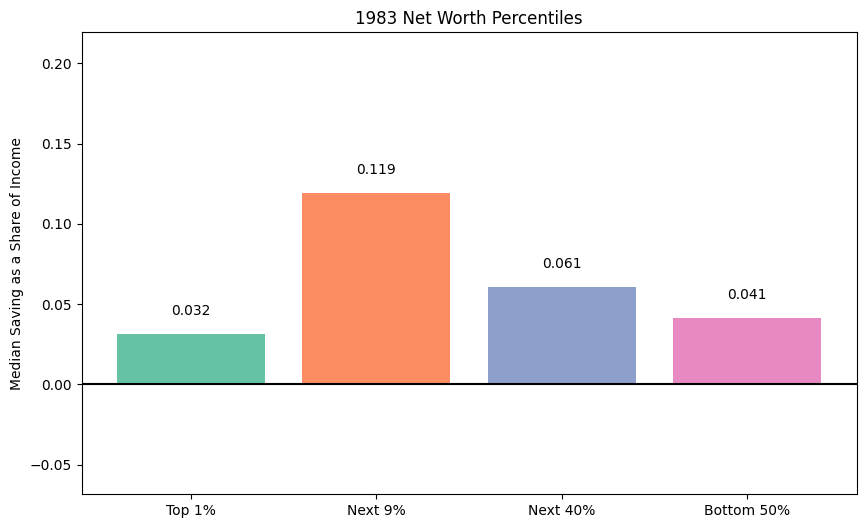

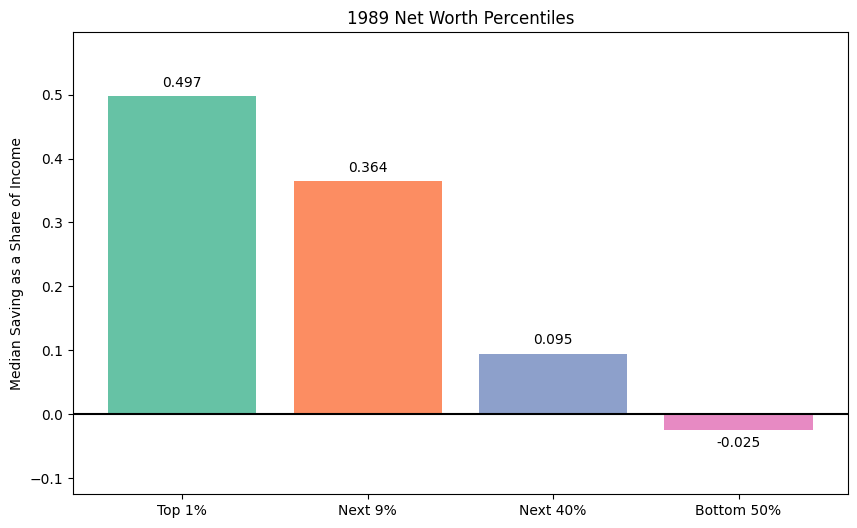

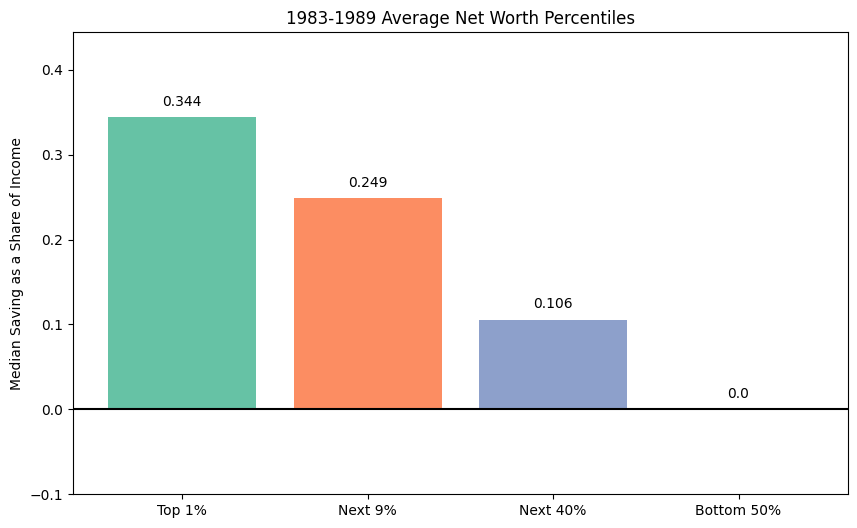

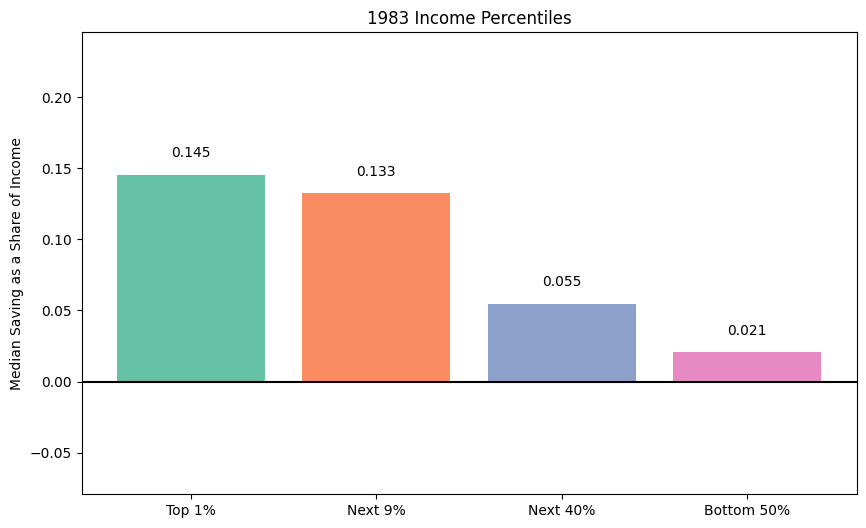

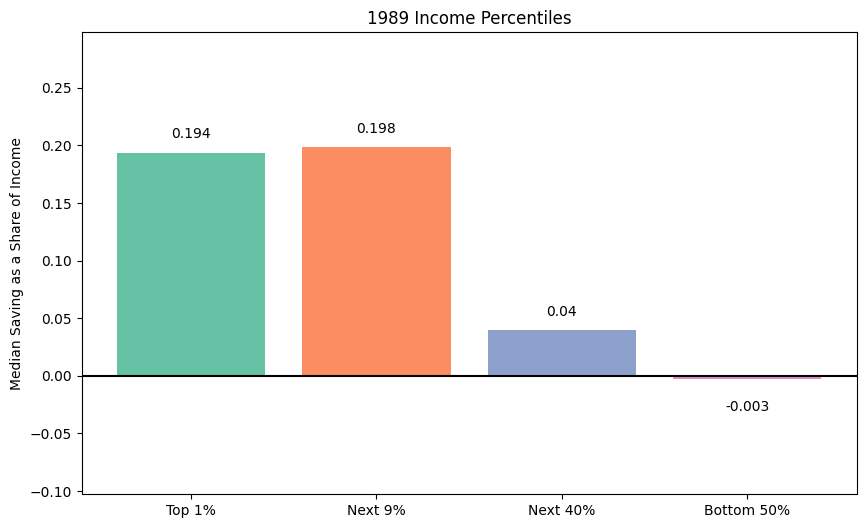

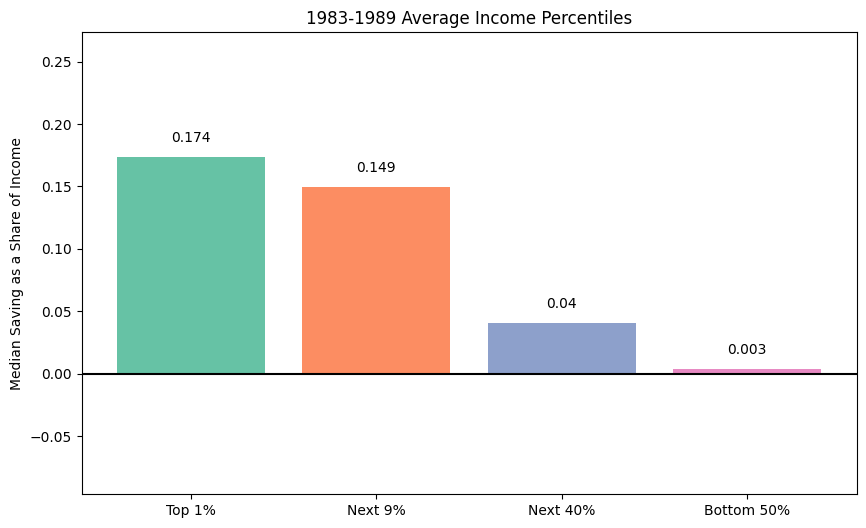

In [13]:
pcols = [col for col in scf.columns if 'percentile_' in col]

for percentile_col in pcols:
    
    
    if 'tinc' in percentile_col:
        sort = 'tinc'
        sort_name = 'Income'
    else:
        sort = 'nw'
        sort_name = 'Net Worth'
    sort_year = percentile_col.replace(sort, '').replace('percentile_','')
    if sort_year=='av':
        sort_year = '1983-1989 Average'

    plot_savings_bar(scf, percentile_col=percentile_col, sort_year=sort_year, sort_name=sort_name, tag='', weight_var='wgtxinc')

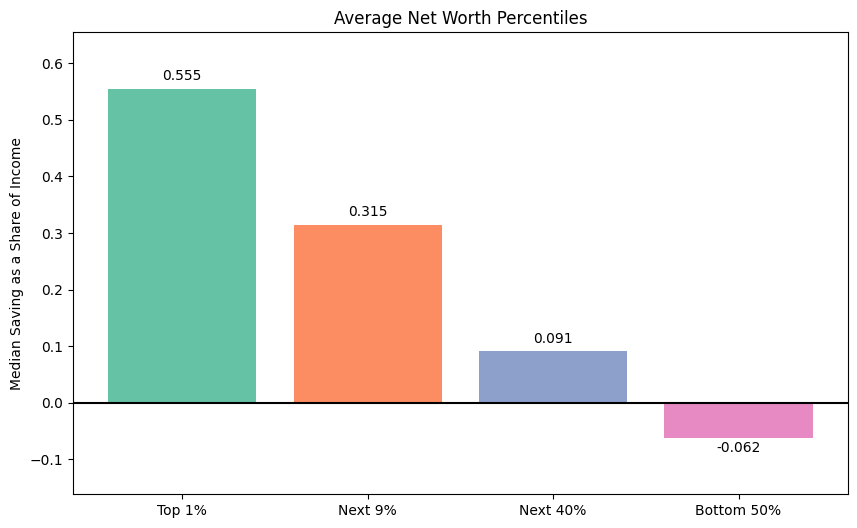

In [38]:
# Restrict to stable sample
scf_restricted = scf[(scf.ageh1983>=30)&(scf.ageh1983<=65)&(scf.hh_change==0)&(scf.tinc1983>1000)&(scf.tinc1989>1000)]

plot_savings_bar(scf_restricted, tag='_stable', weight_var='wgtxinc')

# Compare saving to disposable income by percentile in SCF vs FOF

In [15]:
df = load_data('fof_savings_p100.csv') 
dina = load_data('dina_hwealsort_100.csv', folder='working')
df = df.merge(dina, on=['Year','Percentile'])
df['FOFsaving2DI'] = df['FOFsaving']/(df['peinc']/1e6)
df = df[df.Year.between(1983,1989,inclusive='both')]
df_group = df.groupby('Percentile')[['FOFsaving2DI','peinc']].mean().reset_index()

In [16]:
# Group by percentile and compute the weighted median
scf['percentile'] = scf.percentile_nwav.apply(lambda x: np.ceil(x/5)*5)
scf_group = scf.groupby('percentile').apply(lambda x: weighted_median(x, 'saving_rate', 'wgtxinc'),include_groups=False).reset_index().rename(columns={0:'saving2DI'})

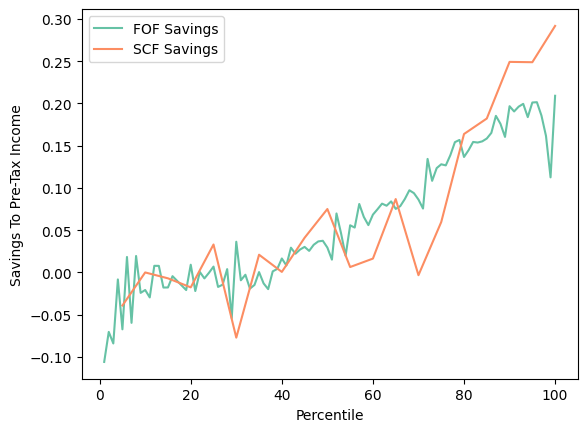

In [18]:
plt.plot(df_group.Percentile, df_group.FOFsaving2DI, label='FOF Savings')
plt.plot(scf_group.percentile, scf_group.saving2DI, label='SCF Savings')
plt.legend()
plt.ylabel('Savings To Pre-Tax Income')
plt.xlabel('Percentile')

plt.savefig(os.path.join(figures_folder, f'scf_saving_vs_fof_line.png'), dpi=300, bbox_inches='tight')

In [19]:
# Group into 4 bins
df = group_percentiles(df, 'Percentile')
fof = df.groupby('percentile')['FOFsaving2DI'].mean().reset_index().rename(columns={'FOFsaving2DI':'saving2DI'})

In [20]:
# Group by percentile and compute the weighted median
scf = group_percentiles(scf, 'percentile_nwav')
scf_group = scf.groupby('percentile').apply(lambda x: weighted_median(x, 'saving_rate', 'wgtxinc'),include_groups=False).reset_index().rename(columns={0:'saving2DI'})

[(0.2923363702661794, 0.5107465581015513, 0.3906173846714218),
 (0.47240052392487, 0.634960192014971, 0.5450455573028572),
 (0.6599575815471139, 0.7643426549871792, 0.7058998588626949),
 (0.8400217352058045, 0.8885562889005989, 0.8603280314941303),
 (0.9078483610385412, 0.8583916401016528, 0.916562306914319),
 (0.8267950630305225, 0.6867532554984255, 0.8507815765170651),
 (0.7423689416950218, 0.5079725835150615, 0.7822635511862883),
 (0.6613156436870031, 0.33633419891183414, 0.7164828207890344)]

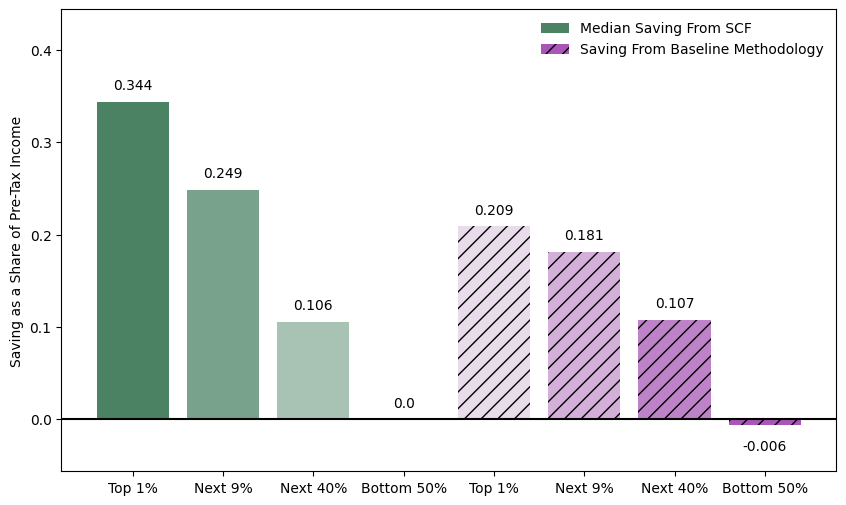

In [36]:
p_dict = {
    1:'Top 1%',
    9:'Next 9%',
    40:'Next 40%',
    50:'Bottom 50%'
}

# Sample data
xaxis = []
percentiles = []
values = []
colors = sns.diverging_palette(145, 300, s=60, n=8)
hatches = ['']*4 + ['//']*4

count = 0
for j, dataframe in enumerate([scf_group,fof]):
    for i, p in enumerate([1,9,40,50]):
        percentiles.append(p_dict[p])
        xaxis.append(count)
        values.append(dataframe[dataframe.percentile==p].saving2DI.item())
        count+=1

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(xaxis, values, color=colors, hatch=hatches)

for bar in bars:
    yval = bar.get_height()
    adj = 0.01 if yval>=0 else -0.03
    ax.text(bar.get_x() + bar.get_width()/2, yval+adj, round(yval, 3), ha='center', va='bottom')

# Set custom x-tick labels
ax.set_xticks(xaxis)
ax.set_xticklabels(percentiles)

ax.set_ylim([np.min(values)-0.05, np.max(values)+0.1])
ax.set_ylabel('Saving as a Share of Pre-Tax Income')

ax.axhline(0, color='black')

# Add legend
fig.legend(handles=[bars[0]]+[bars[-1]], labels=['Median Saving From SCF', 'Saving From Baseline Methodology'], bbox_to_anchor=(0.9, 0.88), loc='upper right', ncol=1, frameon=False)

plt.savefig(os.path.join(figures_folder, f'scf_saving_vs_fof_bar.png'), dpi=300, bbox_inches='tight')


In [160]:
scf

,id1983,id1989,wgt0296,saving,wgt0195,hh_change,savbnd1989,hdebt1989,pdebt1989,ageh1989,...,percentile_nw1989,nwav,percentile_nwav,percentile_tinc1983,percentile_tinc1989,tincav,percentile_tincav,saving_rate,percentile,wgtxinc
0,23,3164,"52,147.080","-1,914.005","56,943.757",0,0,"22,000.000",39400,70,...,32,"10,990.000",30,61,41,"23,229.660",49,-0.082,50,"1,211,358,929.759"
1,28,3465,"23,546.332",-74.555,"58,810.622",0,0,0.000,5500,83,...,28,"6,127.000",25,24,15,"9,532.967",16,-0.008,50,"224,466,403.071"
2,37,4658,"92,631.574",840.336,"96,776.671",0,300,0.000,2550,47,...,27,"2,470.000",20,80,63,"36,412.398",72,0.023,50,"3,372,937,726.657"
3,42,3351,"37,069.108","-23,340.193","39,660.012",0,0,0.000,0,73,...,64,"111,842.000",79,55,56,"26,226.566",55,-0.890,40,"972,195,418.868"
4,43,4089,"20,958.437","3,909.171","52,346.952",0,6000,0.000,0,90,...,56,"38,600.000",52,21,20,"10,242.167",17,0.382,40,"214,659,812.411"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1474,4270,4630,"1,724.001","40,801.774","2,047.884",0,0,"55,000.000",0,71,...,100,"1,775,313.500",100,100,100,"461,497.940",100,0.088,1,"795,622,757.565"
1475,4271,4516,441.541,"1,251,819.840",702.809,0,0,"250,000.000",0,69,...,100,"8,449,200.000",100,100,100,"1,270,416.800",100,0.985,1,"560,941,012.761"
1476,4272,4011,"1,724.001","12,027.460","2,047.884",0,0,0.000,0,80,...,99,"1,741,905.500",100,100,100,"396,493.250",100,0.030,1,"683,554,628.479"
1477,4280,3293,"32,469.561",511.991,"34,192.211",0,0,0.000,8200,46,...,26,"3,492.000",21,52,80,"35,420.055",71,0.014,50,"1,150,073,649.674"


In [179]:
sub = scf[scf.percentile_nwav <= 50]
DS = DescrStatsW(sub['saving_rate'], weights=sub['wgtxinc'])
DS.quantile([0.01,0.05,0.1,0.25,0.5,0.75,0.9,0.95,0.99])

p
0.010   -0.514
0.050   -0.306
0.100   -0.198
0.250   -0.090
0.500    0.000
0.750    0.069
0.900    0.189
0.950    0.269
0.990    0.440
dtype: float64

In [180]:
DS.mean

-0.0073334973223552966